In [1]:
from fastplotlib import Plot
from ipywidgets import VBox
import numpy as np

### Simple image

RFBOutputContext()


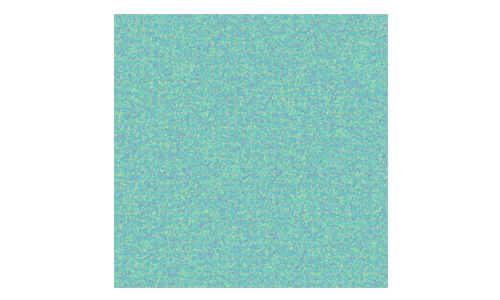

JupyterWgpuCanvas()

In [2]:
plot = Plot()

data = np.random.rand(512, 512) * 255
plot.image(data=data,  vmin=0, vmax=255, cmap='viridis')

plot.show()

### Update image (video)

RFBOutputContext()


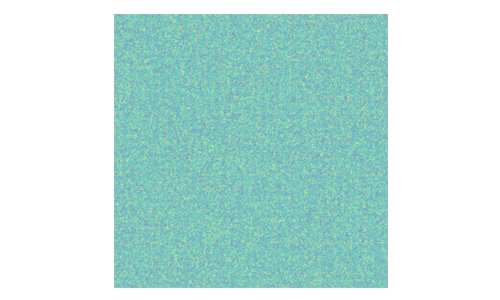

JupyterWgpuCanvas()

In [3]:
plot = Plot()

data = np.random.rand(512, 512) * 255
image = plot.image(data=data,  vmin=0, vmax=255, cmap='viridis')

def update_data():
    new_data = np.random.rand(512, 512) * 255
    image.update_data(new_data)

plot.add_animations([update_data])

plot.show()

### We can share controllers across plots

RFBOutputContext()


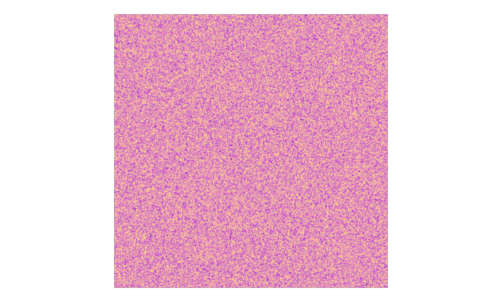

JupyterWgpuCanvas()

In [4]:
plot_sync = Plot(controller=plot.controller)

data = np.random.rand(512, 512) * 255
image_2 = plot_sync.image(data=data,  vmin=0, vmax=255, cmap='plasma')

def update_data_2():
    new_data = np.random.rand(512, 512) * 255
    image_2.update_data(new_data)

plot_sync.add_animations([update_data_2])

plot_sync.show()

### You can also use `ipywidgets.VBox` to stack plots. See the `gridplot` notebooks for a proper gridplot interface for more complex subplotting

In [5]:
VBox([plot.show(), plot_sync.show()])

### 2D line plot

RFBOutputContext()


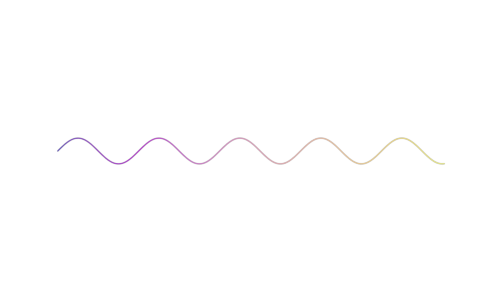

JupyterWgpuCanvas()

In [6]:
plot = Plot()

xs = np.linspace(0, 30, 200)
ys = np.sin(xs)

data = np.dstack([xs, ys])[0]

plot.line(data=data, size=1.5, cmap='plasma')

plot.show()

### 3D line plot

RFBOutputContext()

/home/kushal/Insync/kushalkolar@gmail.com/drive/repos/fastplotlib/fastplotlib/subplot.py:120: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



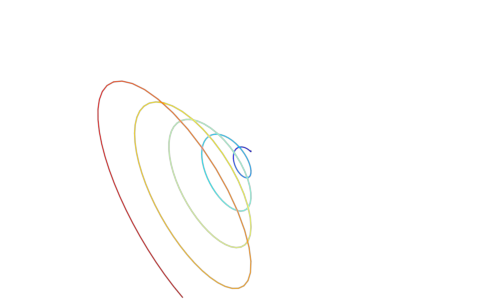

JupyterWgpuCanvas()

In [7]:
plot = Plot(camera='3d')

phi = np.linspace(0, 30, 200)

xs = phi * np.cos(phi)
ys = phi * np.sin(phi)
zs = phi

# data must be 3d, with shape [<n_vertices>, 3]
spiral = np.dstack([xs, ys, zs])[0]

plot.line(data=spiral, size=1.5, cmap='jet')

plot.show()